# Fantasy Football - Optimal Drafting Guide and Predictions

### Goals:  
1. Create a PPR drafting strategy guide.
    - Round by round analysis
    - General drafting principles
      
2. Create 2023 player ppr projections and tier list

In [1]:
# Imports
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

import xgboost 

from sklearn.preprocessing import StandardScaler, RobustScaler

import explore_functions as e
import modeling_functions as m
from prepare import x_y_split, rmse

In [2]:
# Load dataframe
df = pd.read_csv('season.csv',index_col=0)
df = df.sort_values('year').reset_index(drop=True)

# Exploration

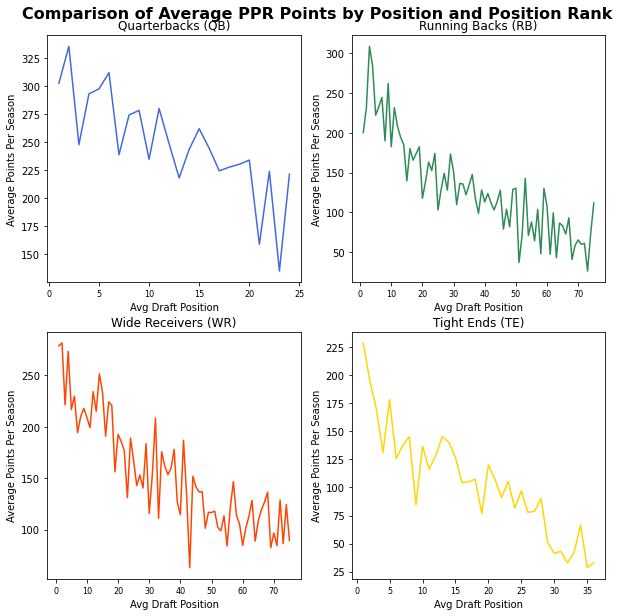

In [3]:
# Create visualizations
e.avg_pts_by_adp(df)

### Viz Takeaways

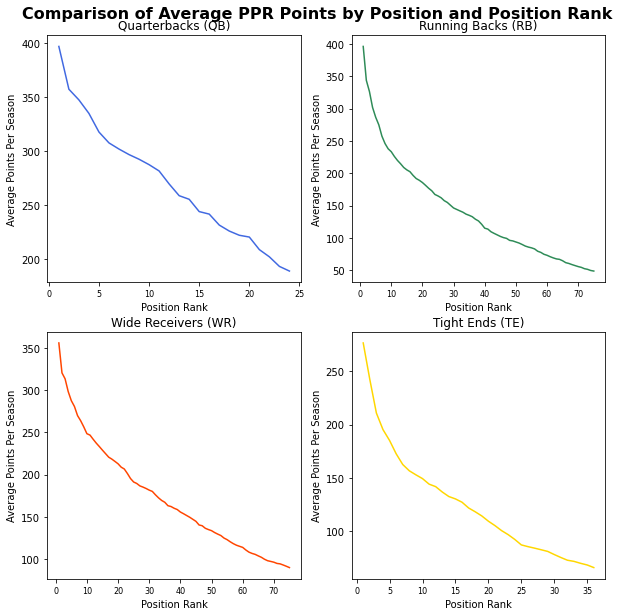

In [4]:
# Create visualizations
e.pnt_avg_by_pos_rank(df)

### Viz Takeaways

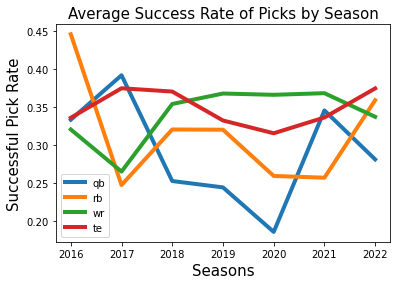

In [5]:
# Create visualizations
success_rate = pd.read_csv('success_rate.csv')
e.success_rate_by_season(success_rate)

### Viz Takeaways

# Modeling

In [6]:
# Add 'target' column, create df for each position
df = df.groupby('player').apply(m.add_target)
qb_df, rb_df, wr_df, te_df = m.split_pos(df)

In [9]:
# Model and predict
qb_cols = ['age','g','gs','pass_yds','pass_tds','rush_att','rush_yard','y/a','rush_tds',
           'fmb','fl','rush_rec_tds','pos_rank','avg_draft_pos','avg_draft_pos_ppr','adp_by_pos','round','ppr_pts']

preds, val_preds, pos_2022 = m.xgb_modeling(qb_df, qb_cols)

In [13]:
# Print out projections
pos_2022.sort_values('preds',ascending = False).head(12)

,player,preds
3395,Joe Burrow,367.976776
3396,Jalen Hurts,364.150757
3394,Geno Smith,323.994904
3387,Tom Brady,312.576752
3390,Daniel Jones,307.957794
3391,Kirk Cousins,303.653717
3389,Jared Goff,288.677765
3392,Trevor Lawrence,284.144073
3397,Josh Allen,281.513763
3388,Justin Herbert,263.596619


In [14]:
# Model and predict
rb_cols = ['age','g','gs','rush_att','rush_yard','y/a','rush_tds','tgt','rec','rec_yards','y/r','rec_tds','fmb',
           'fl','rush_rec_tds','ppr_pts','pos_rank','avg_draft_pos','avg_draft_pos_ppr','adp_by_pos','round']

preds, val_preds, pos_2022 = m.xgb_modeling(rb_df, rb_cols)

# Print out predictions
pos_2022.sort_values('preds',ascending = False).head(12)

,player,preds
3320,Christian McCaffrey,362.514130
3318,Josh Jacobs,331.082764
3316,Saquon Barkley,298.524139
3315,Nick Chubb,288.308929
3317,Derrick Henry,260.457367
3313,Tony Pollard,257.988953
3314,Rhamondre Stevenson,253.972076
3308,Jamaal Williams,233.003128
3310,Dalvin Cook,231.044296
3307,Najee Harris,221.920471


In [15]:
# Model and predict
wr_cols = ['age','g','gs','tgt','rec','rec_yards','y/r','rec_tds','fmb','fl','rush_rec_tds','ppr_pts','pos_rank',
           'avg_draft_pos','avg_draft_pos_ppr','adp_by_pos','round']

preds, val_preds, pos_2022 = m.xgb_modeling(wr_df, wr_cols)

# Print out predictions
pos_2022.sort_values('preds',ascending = False).head(12)

,player,preds
3467,Stefon Diggs,316.793213
3450,Tyreek Hill,307.295532
3468,CeeDee Lamb,304.083038
3497,A.J. Brown,290.712189
3466,Davante Adams,283.060852
3496,Amon-Ra St. Brown,252.286362
3493,Amari Cooper,249.445847
3437,Justin Jefferson,249.001511
3492,Ja'Marr Chase,243.721786
3489,Terry McLaurin,243.436295


In [16]:
# Model and predict
te_cols = ['age','g','gs','tgt','rec','rec_yards','y/r','rec_tds','fmb','fl','rush_rec_tds','ppr_pts','pos_rank',
           'avg_draft_pos','avg_draft_pos_ppr','adp_by_pos','round']

preds, val_preds, pos_2022 = m.xgb_modeling(te_df, te_cols)

# Print out predictions
pos_2022.sort_values('preds',ascending = False).head(12)

,player,preds
3246,T.J. Hockenson,236.554871
3245,George Kittle,234.406723
3244,Mark Andrews,220.582916
3243,Evan Engram,205.202835
3241,Pat Freiermuth,183.579620
3302,David Njoku,147.496857
3242,Tyler Higbee,147.099533
3240,Cole Kmet,142.579346
3299,Juwan Johnson,141.930374
3297,Noah Fant,131.515518


# Recommendations

# Next Steps